In [4]:
import importlib
import shiftNMF
importlib.reload(shiftNMF)
from shiftNMF import ShiftNMF
from nnls_l1 import nnls
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from helpers.generators import *
from helpers.data import X_WINE, PPM_WINE
import Hardmodel_single_peaks
importlib.reload(Hardmodel_single_peaks)
from Hardmodel_single_peaks import Single_Model
from Hardmodel import Hard_Model
import scipy
from scipy.signal import find_peaks
import itertools
import torch

import helpers.fit_functions 
importlib.reload(helpers.fit_functions)
from helpers.fit_functions import *

# shiftNMF

[5.99978451 5.99915313 5.99852176 ... 0.50114961 0.50051823 0.49988686]
3.600563858141756
3.474289087241136


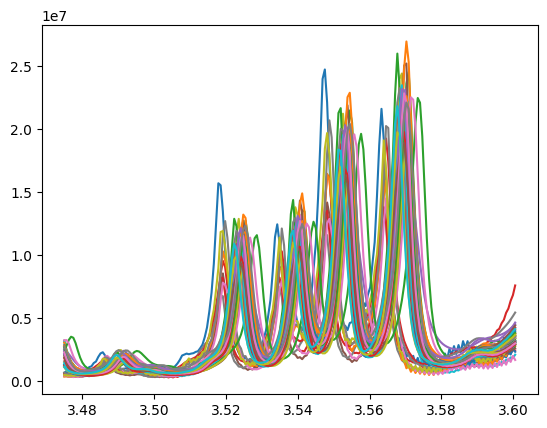

In [5]:
si = 3800
ei = 4000
print(PPM_WINE)
X = X_WINE[:,si:ei]
print(PPM_WINE[si])
print(PPM_WINE[ei])
ppm = PPM_WINE[si:ei]

plt.plot(ppm,X.T)
#flip x axis
# plt.gca().invert_xaxis()
plt.show()

epoch: 1000, Loss: 0.015005675952642319, Tau: 294.12752336359137


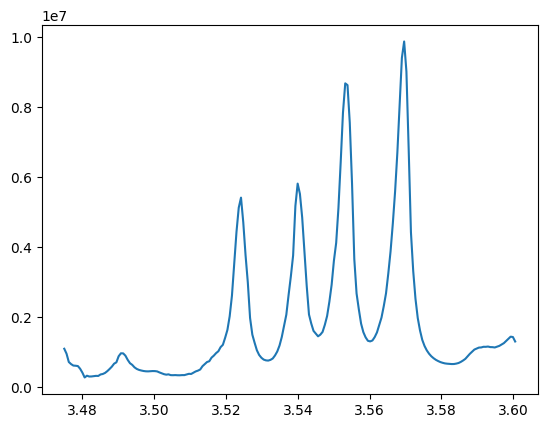

In [6]:
torch.manual_seed(42)
nmf = ShiftNMF(X, 1, lr=0.1, alpha=1e-6, patience=30, min_imp=-10000)
W_est, H_est, tau_est = nmf.fit(verbose=1, max_iter=1000, tau_iter=0, Lambda=0.000)
plt.plot(ppm,H_est.T)
plt.show()


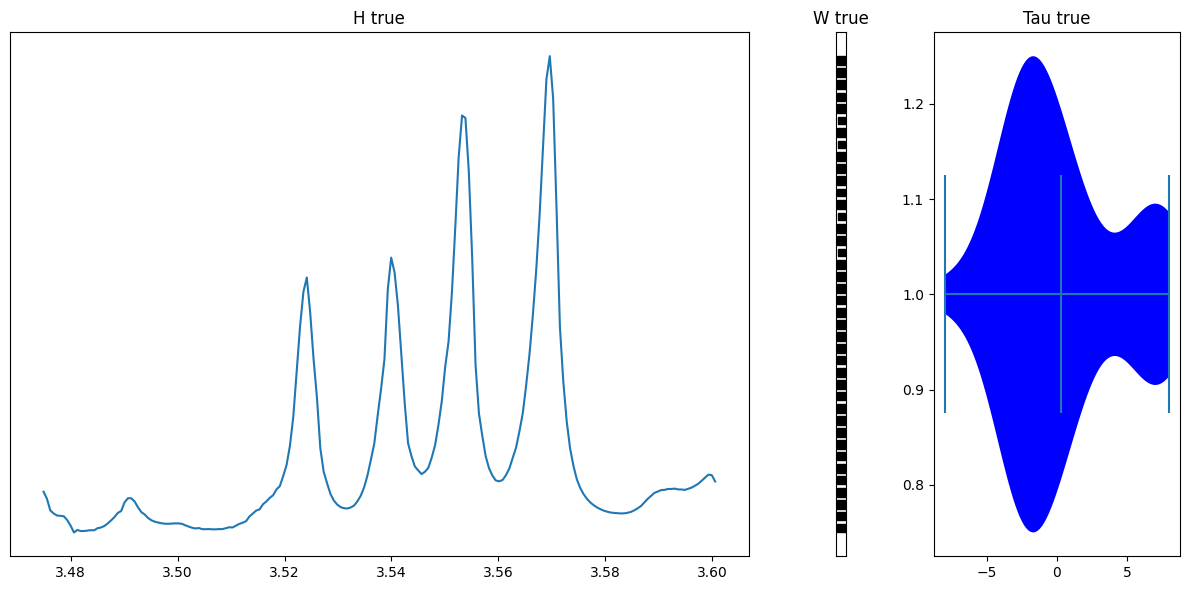

In [7]:
from helpers.plot import *
gs = gridspec.GridSpec(1, 3, width_ratios=[3, 1, 1])

fig = plt.figure(figsize=(12, 6))
N, M = X[:,0:3000].shape
H_scaled = np.zeros_like(H_est)
for i, vec in enumerate(H_est):
    H_scaled[i] = vec/max(vec)

# Plot H and H_est
ax1 = plt.subplot(gs[0])
plotSpaced(ax1, ppm, H_scaled.T)
ax1.set_title('H true')

ax2 = plt.subplot(gs[1])
ax2.set_title('W true')
hinton(W_est.T, ax=ax2)

ax3 = plt.subplot(gs[2])
violin_parts = ax3.violinplot(tau_est, showmeans=True, showmedians=False, vert=False)
ax3.set_title('Tau true')
change_violin_colors(violin_parts, color_list=['blue']*N)
# change_violin_colors(violin_parts, [l.get_color() for l in ax3.get_children()[:3]])

# Set tight layout
plt.tight_layout()
plt.show()

# Hardmodel

Found peaks:[ 49  75  96 121]
sigma: 7.668771305490278 n:0.12824082886274676
sigma: 6.9017928926719705 n:0.4008617569482457
sigma: 6.318853175881044 n:0.8274645524126547
sigma: 6.87386177756959 n:0.84113294172924
Lorentzian %:oss: 0.052176075424279754
tensor([0.9590, 0.9563, 0.9999, 0.9999], grad_fn=<SigmoidBackward0>)
Sigma:
Parameter containing:
tensor([6.8354, 6.8015, 7.4465, 7.9989], requires_grad=True)
HERER ARE THE SINGLE FITS SIGMAS
[6.8353796 6.801517  7.446512  7.9989214]
hypothesises:
{(0, 1), (1, 3), (2,), (1, 2), (0, 1, 2), (0, 1, 3), (0, 3), (0, 2, 3), (1, 2, 3), (2, 3), (1,), (0, 2), (0, 1, 2, 3), (0,), (3,)}
Loss: 0.06065797211166405
means:
[ 62.  108.5  72.5]
sigmas:
[6.818448 7.722717 7.140946]
J coupling:
[26. 25. 47.]
multiplicity
[2 2 2]
N
[0.95767933 0.99987376 0.9978231 ]
W:
[[10.349249    0.          0.          0.          0.          0.
   0.          0.          0.          8.734125    0.          0.89156276
   0.          0.          0.        ]]


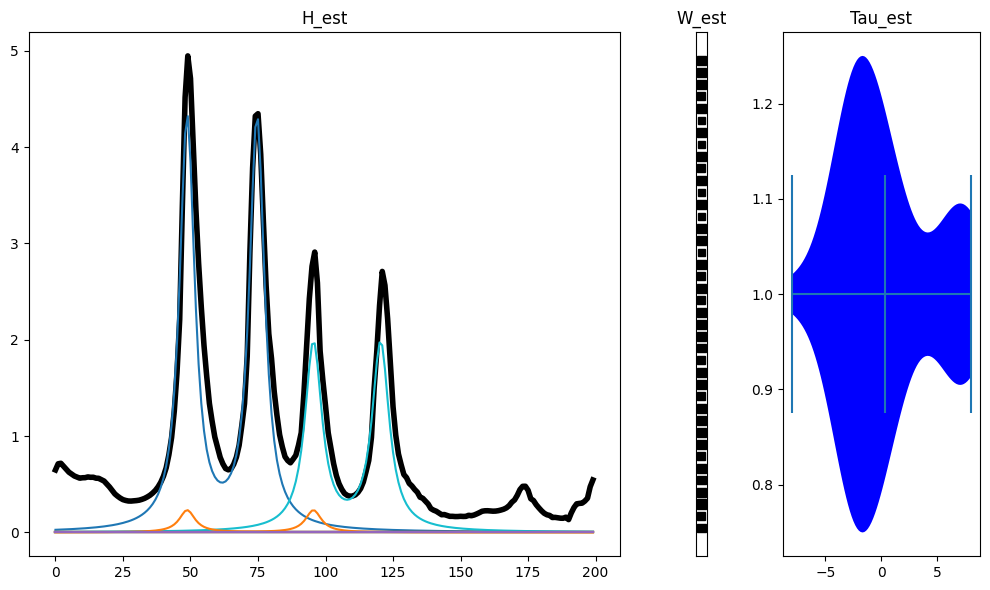

In [8]:

fig = plt.figure(figsize=(10, 6))
# Create a gridspec object with 2 rows and 3 columns
gs = gridspec.GridSpec(1, 3, width_ratios=[3, 1, 1])

# Plot H and H_est
ax1 = plt.subplot(gs[0])
# plotSpaced(ax1, np.arange(H_est.shape[1]), H_est.T)
ax1.set_title('H_est')
x = np.arange(H_est.shape[1])

ax2 = plt.subplot(gs[1])
ax2.set_title('W_est')
hinton(W_est.T, ax=ax2)

ax3 = plt.subplot(gs[2])
violin_parts = ax3.violinplot(tau_est, showmeans=True, showmedians=False, vert=False)
ax3.set_title('Tau_est')
change_violin_colors(violin_parts, color_list=['blue']*3)
# change_violin_colors(violin_parts, [l.get_color() for l in ax3.get_children()[:3]])

# plt.figure(figsize=(15,5))
# plt.plot(H_est.T)
# plt.savefig("shiftcomponents")
# plt.clf()
ymax = 0
for i in range(len(H_est)):
    ymax = max(ymax,(H_est[i]/np.std(H_est[i])).max())
yoffset = ymax
reg_paths = []
lambda_axis = []
C_path = []
losses = []

for i in range(len(H_est)):
    means, sigmas, n = single_fit(H_est[i], min_height=0.5, min_sigma=1, lr=0.1)
    #diff_matrix = calc_difference_matrix(sigmas)
    print("HERER ARE THE SINGLE FITS SIGMAS")
    print(sigmas)
    diff_matrix = calc_difference_matrix(np.ones((len(sigmas))))
    hypothesis = peak_hypothesis(diff_matrix, cutoff=10/100)
    hardmodel = Hard_Model(H_est[i], hypothesis, means, sigmas, n)
    
    W, C, running_loss, path, lambdas, loss = hardmodel.fit(verbose=True, return_loss=True, threshold=0.15)
    reg_paths.append(path)
    lambda_axis.append(lambdas)
    C_path.append(C)
    losses.append(loss)
    means, sigma, j_coup, mult, n, w = hardmodel.return_values()
    print("means:")
    print(means)
    print("sigmas:")
    print(sigma)
    print("J coupling:")
    print(j_coup)
    print("multiplicity")
    print(mult)
    print("N")
    print(n)

    print("W:")
    print(W)
    ## TODO change this to be the true underlying components from H_ART not the shift found components, they need to be scaled accordingly.
    # plt.figure(figsize=(15,5))
    # plt.plot(H_est[i]/np.std(H_est[i]), linewidth=5, color="k")
    ax1.plot(x,H_est[i]/np.std(H_est[i])+yoffset*i, linewidth=4, color="k")
    for j, vec in enumerate(C):
        ax1.plot(x,vec*W[:,j]+yoffset*i)
# Set tight layout
plt.tight_layout()
plt.show()

In [9]:
print([ppm[int(i)] for i in means])
print([ppm[0] - ppm[int(i)] for i in j_coup])

[3.561418679162564, 3.5323754818554214, 3.555104940617534]
[0.016415720217079155, 0.01578434636257775, 0.029674571161645957]


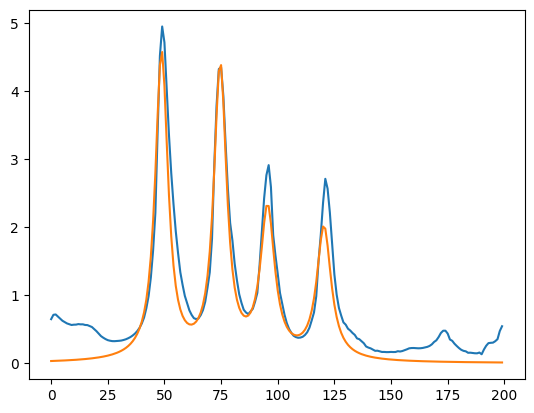

In [10]:
plt.plot(H_est[0]/np.std(H_est[i]))
plt.plot(np.dot(W,C).T)
# for j, vec in enumerate(C):
    # plt.plot(vec*W[:,j])
# plt.plot(C[9])
# plt.plot(C[0])

[1.0, 0.5973850254323202, 0.3512012181602915, 0.24733677159205997, 0.22624609531274587, 0.21761103812148194, 0.21515060107986822, 0.2151031449270047, 0.2140657249031745, 0.21405992705564805, 0.2139810303477562, 0.21397861162396697]
[ 0  9 11  6  5  3 10 14 13 12  8  7  4  2  1]


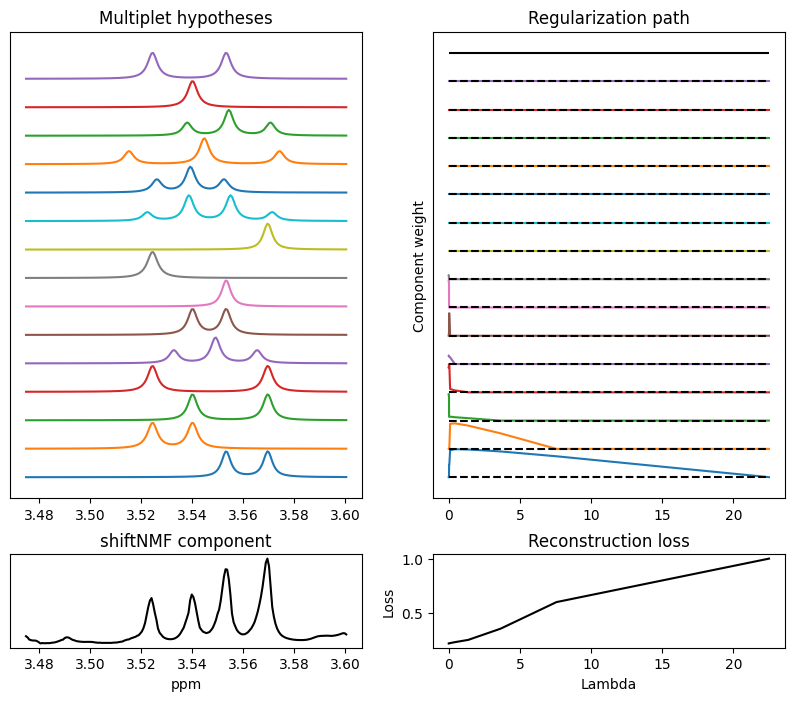

<Figure size 640x480 with 0 Axes>

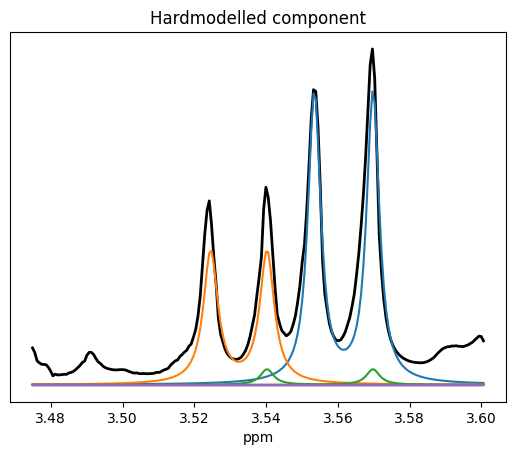

In [11]:
for i in range(len(reg_paths)):
    path = reg_paths[i][0]
    lambdas = lambda_axis[i][0]
    C = C_path[i]
    loss = losses[i]
    print(loss)
    fig = plt.figure(figsize=(10, 8))
    # Create a gridspec object with 2 rows and 3 columns
    gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[10,2])

    # Plot H and H_est
    ax1 = plt.subplot(gs[0])
    # plotSpaced(ax1, np.arange(H_est.shape[1]), H_est.T)
    ax1.set_title('Multiplet hypotheses')

    # ax1.set_xlabel("ppm")
   
    x = np.arange(H_est.shape[1])

    ax2 = plt.subplot(gs[1])
    ax2.set_title('Regularization path')
    # ax2.set_xlabel("Lambda")
    ax2.set_ylabel("Component weight")

    ax1.tick_params(left = False, labelleft = False)
    ax2.tick_params(left = False, labelleft = False)

    ax3 = plt.subplot(gs[2])
    # plotSpaced(ax1, np.arange(H_est.shape[1]), H_est.T)
    ax3.set_title('shiftNMF component')
    ax3.plot(ppm, H_est[i]/max(H_est[i]), color="k")
    ax3.set_xlabel("ppm")
    #hide y axis
    ax3.yaxis.set_visible(False)

    ax4 = plt.subplot(gs[3])
    # plotSpaced(ax1, np.arange(H_est.shape[1]), H_est.T)
    ax4.set_title('Reconstruction loss')
    ax4.plot(lambdas, loss, color="k")
    ax4.set_xlabel("Lambda")
    ax4.set_ylabel("Loss")
    
    #flip x axis on ax1 and ax3
    # ax1.invert_xaxis()
    # ax3.invert_xaxis()
   
    # sort_indices = np.argsort([np.trapz(p,lambdas) for p in path])
#     sort_indices = np.argsort(np.count_nonzero(path>5, axis=1))[::-1]
    non_zero = []
    sort_indices = []
    for j in range(len(path)):
        #reverse the path so we start from the end
        #get the last time number in the path was non zero
        path_temp = path[j][::-1]
        try:
            last_non_zero = np.where(path_temp>0)[0][-1]
            pass
        except:
            last_non_zero = 0
        sort_indices.append(last_non_zero)
        # print(last_non_zero)

    sort_indices = np.argsort(sort_indices)[::-1]
    
    print(sort_indices)
    path = path[sort_indices]
    C = C[sort_indices]
    W_sort = W[0][sort_indices]

    ymax = 1.1
    yoffset = ymax
    t = 0

    nr_of_components = len(C)

    for j in range(nr_of_components):
            ax1.plot(ppm,C[j]/max(C[j])+yoffset*t)
            t += 1

    
    ymax = path.max()
    yoffset = ymax
    t = 0
    for j in range(nr_of_components):
            ax2.plot(lambdas,path[j]+yoffset*t)
            ax2.hlines(yoffset*t,lambdas[-1],lambdas[0], color="k", linestyle="--")
            t +=1
    ax2.hlines(yoffset*t,lambdas[-1],lambdas[0], color="k")


    
    # ax3.plot(ppm,H_est[0]/np.std(H_est[0])+yoffset*i, linewidth=4, color="k")
#     print(W)

    #heights
    # max_val = 0
    # for j, vec in enumerate(C):
    #     val = max(vec*W_sort[j])
    #     if val > max_val:
    #         max_val = val
    # for j, vec in enumerate(C):
    #     # print(W[j])
    #     ax3.plot(ppm,vec*W_sort[j]/max_val)

    #hide y axis labels
    ax3.yaxis.set_visible(False)
    #set x axis label
    # ax.set_xticks(ppm)
    
    plt.show()
    plt.tight_layout()
    
    fig, ax = plt.subplots()
    
    ax.plot(ppm,H_est[i]/np.std(H_est[i]), linewidth=2, color="k")
    for j, vec in enumerate(C):
        # print(W[j])
        ax.plot(ppm,vec*W_sort[j])
    
    ax.set_title("Hardmodelled component")
    ax.set_xlabel("ppm")
    #hide y axis
    ax.yaxis.set_visible(False)
    # ax.invert_xaxis()
    plt.show()
    
    
    
    # fig, ax = plt.subplots()
# print(len(x))
# print(len(ppm))

[1.0, 0.5973850254323202, 0.3512012181602915, 0.24733677159205997, 0.22624609531274587, 0.21761103812148194, 0.21515060107986822, 0.2151031449270047, 0.2140657249031745, 0.21405992705564805, 0.2139810303477562, 0.21397861162396697]
[ 0  9 11  6  5  3 10 14 13 12  8  7  4  2  1]


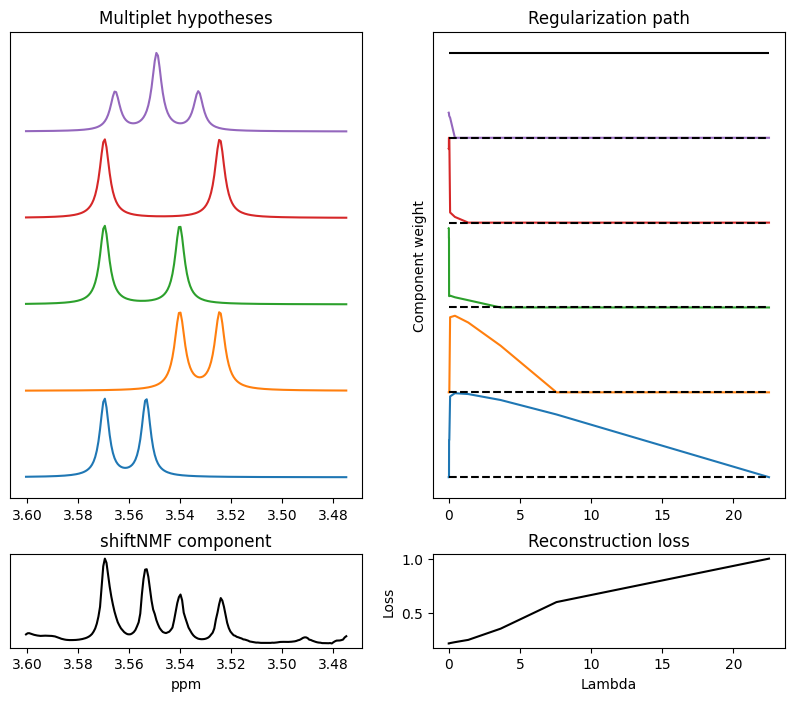

<Figure size 640x480 with 0 Axes>

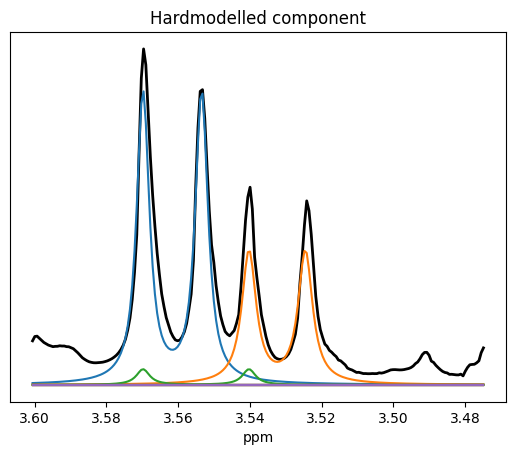

In [12]:
for i in range(len(reg_paths)):
    path = reg_paths[i][0]
    lambdas = lambda_axis[i][0]
    C = C_path[i]
    loss = losses[i]
    print(loss)
    fig = plt.figure(figsize=(10, 8))
    # Create a gridspec object with 2 rows and 3 columns
    gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[10,2])

    # Plot H and H_est
    ax1 = plt.subplot(gs[0])
    # plotSpaced(ax1, np.arange(H_est.shape[1]), H_est.T)
    ax1.set_title('Multiplet hypotheses')

    # ax1.set_xlabel("ppm")
   
    x = np.arange(H_est.shape[1])

    ax2 = plt.subplot(gs[1])
    ax2.set_title('Regularization path')
    # ax2.set_xlabel("Lambda")
    ax2.set_ylabel("Component weight")

    ax1.tick_params(left = False, labelleft = False)
    ax2.tick_params(left = False, labelleft = False)

    ax3 = plt.subplot(gs[2])
    # plotSpaced(ax1, np.arange(H_est.shape[1]), H_est.T)
    ax3.set_title('shiftNMF component')
    ax3.plot(ppm, H_est[i]/max(H_est[i]), color="k")
    ax3.set_xlabel("ppm")
    #hide y axis
    ax3.yaxis.set_visible(False)

    ax4 = plt.subplot(gs[3])
    # plotSpaced(ax1, np.arange(H_est.shape[1]), H_est.T)
    ax4.set_title('Reconstruction loss')
    ax4.plot(lambdas, loss, color="k")
    ax4.set_xlabel("Lambda")
    ax4.set_ylabel("Loss")
    
    #flip x axis on ax1 and ax3
    ax1.invert_xaxis()
    ax3.invert_xaxis()
   
    # sort_indices = np.argsort([np.trapz(p,lambdas) for p in path])
#     sort_indices = np.argsort(np.count_nonzero(path>5, axis=1))[::-1]
    non_zero = []
    sort_indices = []
    for j in range(len(path)):
        #reverse the path so we start from the end
        #get the last time number in the path was non zero
        path_temp = path[j][::-1]
        try:
            last_non_zero = np.where(path_temp>0)[0][-1]
            pass
        except:
            last_non_zero = 0
        sort_indices.append(last_non_zero)
        # print(last_non_zero)

    sort_indices = np.argsort(sort_indices)[::-1]
    
    print(sort_indices)
    path = path[sort_indices]
    C = C[sort_indices]
    W_sort = W[0][sort_indices]

    ymax = 1.1
    yoffset = ymax
    t = 0

    nr_of_components = 5

    for j in range(nr_of_components):
            ax1.plot(ppm,C[j]/max(C[j])+yoffset*t)
            t += 1

    
    ymax = path.max()
    yoffset = ymax
    t = 0
    for j in range(nr_of_components):
            ax2.plot(lambdas,path[j]+yoffset*t)
            ax2.hlines(yoffset*t,lambdas[-1],lambdas[0], color="k", linestyle="--")
            t +=1
    ax2.hlines(yoffset*t,lambdas[-1],lambdas[0], color="k")


    
    # ax3.plot(ppm,H_est[0]/np.std(H_est[0])+yoffset*i, linewidth=4, color="k")
#     print(W)

    #heights
    # max_val = 0
    # for j, vec in enumerate(C):
    #     val = max(vec*W_sort[j])
    #     if val > max_val:
    #         max_val = val
    # for j, vec in enumerate(C):
    #     # print(W[j])
    #     ax3.plot(ppm,vec*W_sort[j]/max_val)

    #hide y axis labels
    ax3.yaxis.set_visible(False)
    #set x axis label
    # ax.set_xticks(ppm)
    
    plt.show()
    plt.tight_layout()
    
    fig, ax = plt.subplots()
    
    ax.plot(ppm,H_est[i]/np.std(H_est[i]), linewidth=2, color="k")
    for j, vec in enumerate(C):
        # print(W[j])
        ax.plot(ppm,vec*W_sort[j])
    
    ax.set_title("Hardmodelled component")
    ax.set_xlabel("ppm")
    #hide y axis
    ax.yaxis.set_visible(False)
    ax.invert_xaxis()
    plt.show()
    
    
    
    # fig, ax = plt.subplots()
# print(len(x))
# print(len(ppm))

In [13]:
sort_indices

array([ 0,  9, 11,  6,  5,  3, 10, 14, 13, 12,  8,  7,  4,  2,  1],
      dtype=int64)

In [14]:

non_zero = []
for i in range(len(path)):
    #reverse the path so we start from the end
    #get the last time number in the path was non zero
    path_temp = path[i][::-1]
    try:
        last_non_zero = np.where(path_temp>0)[0][-1]
        pass
    except:
        last_non_zero = 0
    non_zero.append(last_non_zero)
    # print(last_non_zero)

np.argsort(non_zero)

# non_zero
# convert to a list of

array([ 8,  9, 10, 11, 12, 13, 14,  7,  6,  5,  4,  3,  2,  1,  0],
      dtype=int64)

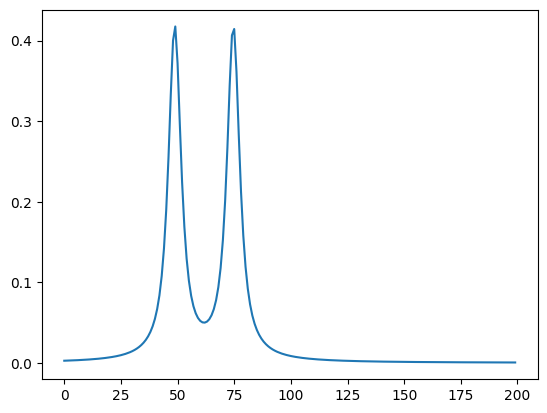

In [15]:
plt.plot(C[0])

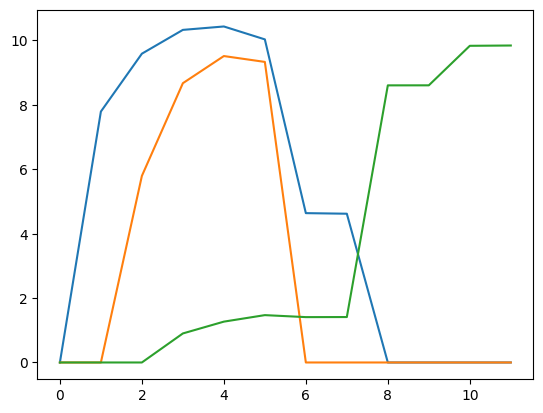

In [16]:
plt.plot(path[0])
plt.plot(path[1])
plt.plot(path[2])
plt.show()

In [17]:
#sort path after last non zero
sort_indices = np.argsort(non_zero)
path_sort = path[sort_indices]


In [18]:
path_sort[-4]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.70924937,
        1.26452589, 10.51449584, 10.54036247, 10.54013087, 10.54438729,
        9.20089191,  9.18328292])

In [19]:
sort_indices

array([ 8,  9, 10, 11, 12, 13, 14,  7,  6,  5,  4,  3,  2,  1,  0],
      dtype=int64)